In [16]:
import random
import torch
import numpy as np
import gym
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os
import h5py

from torch import nn
from collections import deque
from utilities import ReplayMemory, DQN, choose_action_epsilon_greedy, choose_action_softmax, update_step

In [2]:
import glob
import io
import base64
import os
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from gym.wrappers import Monitor

In [3]:
# use LaTeX fonts in plots
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [4]:
display = Display(visible=0, size=(1400, 900))
display.start()

In [5]:
# This code creates a virtual display to draw game images on. 
# If you are running locally, just ignore it
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

In [6]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_videos():
  mp4list = glob.glob('video/*.mp4')
  mp4list.sort()
  for mp4 in mp4list:
    print(f"\nSHOWING VIDEO {mp4}")
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    
def wrap_env(env, video_callable=None):
  env = Monitor(env, './video', force=True, video_callable=video_callable)
  return env

## Policy network

In [7]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
NUM_CLASSES = 10
print(f'Training device:', device)

Training device: cuda:0


In [8]:
# Define an example network
net = DQN(state_space_dim=4, action_space_dim=2).to(device)

## Exploration profile

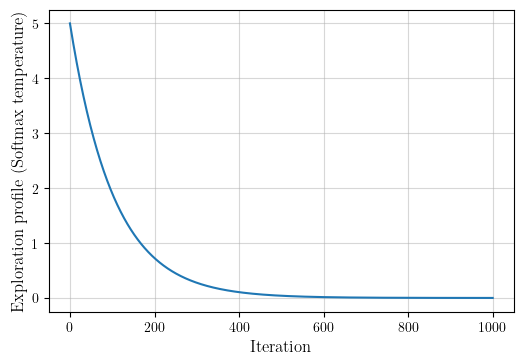

In [9]:
### Define exploration profile
initial_value = 5
num_iterations = 1000
exp_decay = np.exp(-np.log(initial_value) / num_iterations * 6) # We compute the exponential decay in such a way the shape of the exploration profile does not depend on the number of iterations
exploration_profile = [initial_value * (exp_decay ** i) for i in range(num_iterations)]

### Plot exploration profile
plt.figure(dpi=100)
plt.plot(exploration_profile)
plt.grid(alpha=0.5)
plt.xlabel('Iteration', size=12)
plt.ylabel('Exploration profile (Softmax temperature)', size=12);

## Gym Environment (CartPole-v1)

In [10]:
### Create environment
env = gym.make('CartPole-v1') # Initialize the Gym environment
env.seed(0) # Set a random seed for the environment (reproducible results)

# Get the shapes of the state space (observation_space) and action space (action_space)
state_space_dim = env.observation_space.shape[0]
action_space_dim = env.action_space.n

print(f"STATE SPACE SIZE: {state_space_dim}")
print(f"ACTION SPACE SIZE: {action_space_dim}")

STATE SPACE SIZE: 4
ACTION SPACE SIZE: 2


# Part 1: Tweak model parameters to speed up learning

In [11]:
# Set random seeds
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

### PARAMETERS
gamma = 0.97   # gamma parameter for the long term reward 0.97
replay_memory_capacity = 10000   # Replay memory capacity
lr = 1e-3   # Optimizer learning rate
target_net_update_steps = 10   # Number of episodes to wait before updating the target network
batch_size = 128   # Number of samples to take from the replay memory for each update
bad_state_penalty = 0   # Penalty to the reward when we are in a bad state (in this case when the pole falls down) 
min_samples_for_training = 1000   # Minimum samples in the replay memory to enable the training
fname_out = '{gamma}-{replay_memory_capacity}-{lr}-{target_net_update_steps}-{batch_size}-{bad_state_penalty}-{min_samples_for_training}.h5'.format(
    gamma=gamma,
    replay_memory_capacity=replay_memory_capacity,
    lr=lr,
    target_net_update_steps=target_net_update_steps,
    batch_size=batch_size,
    bad_state_penalty=bad_state_penalty,
    min_samples_for_training=min_samples_for_training)

In [12]:
### Initialize the replay memory
replay_mem = ReplayMemory(replay_memory_capacity)

### Initialize the policy network
policy_net = DQN(state_space_dim, action_space_dim).to(device)

### Initialize the target network with the same weights of the policy network
target_net = DQN(state_space_dim, action_space_dim).to(device)
target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

### Initialize the optimizer
optimizer = torch.optim.SGD(policy_net.parameters(), lr=lr) # The optimizer will update ONLY the parameters of the policy network

### Initialize the loss function (Huber loss)
loss_fn = nn.SmoothL1Loss()

In [88]:
# Initialize the Gym environment
env = gym.make('CartPole-v1') 
env.seed(0) # Set a random seed for the environment (reproducible results)

# This is for creating the output video in Colab, not required outside Colab
env = wrap_env(env, video_callable=lambda episode_id: episode_id % 100 == 0) # Save a video every 100 episodes

episode_scores = []

for episode_num, tau in enumerate(tqdm(exploration_profile)):

    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False

    # Go on until the pole falls off
    while not done:

      # Choose the action following the policy
      action, q_values = choose_action_softmax(policy_net, state, temperature=tau, device=device)
      
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)

      # We apply a (linear) penalty when the cart is far from center
      pos_weight = 1
      reward = reward - pos_weight * np.abs(state[0]) 

      # Update the final score (+1 for each step)
      score += 1

      # Apply penalty for bad state
      if done: # if the pole has fallen down 
          reward += bad_state_penalty
          next_state = None

      # Update the replay memory
      replay_mem.push(state, action, next_state, reward)

      # Update the network
      if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
          update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size, device)

      # Visually render the environment (disable to speed up the training)
      env.render()

      # Set the current state for the next iteration
      state = next_state

    # Update the target network every target_net_update_steps episodes
    if episode_num % target_net_update_steps == 0:
        print('Updating target network...')
        target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

    # Print the final score
    print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Temperature: {tau}") # Print the final score
    episode_scores.append(score)

env.close()

  0%|          | 0/1000 [00:00<?, ?it/s]

Updating target network...
EPISODE: 1 - FINAL SCORE: 9 - Temperature: 5.0
EPISODE: 2 - FINAL SCORE: 18 - Temperature: 4.951949240166454
EPISODE: 3 - FINAL SCORE: 19 - Temperature: 4.904360255437024
EPISODE: 4 - FINAL SCORE: 11 - Temperature: 4.857228608082785
EPISODE: 5 - FINAL SCORE: 11 - Temperature: 4.810549903022062
EPISODE: 6 - FINAL SCORE: 25 - Temperature: 4.764319787410582
EPISODE: 7 - FINAL SCORE: 33 - Temperature: 4.7185339502355665
EPISODE: 8 - FINAL SCORE: 19 - Temperature: 4.673188121913726
EPISODE: 9 - FINAL SCORE: 15 - Temperature: 4.628278073893115
EPISODE: 10 - FINAL SCORE: 27 - Temperature: 4.583799618258813
Updating target network...
EPISODE: 11 - FINAL SCORE: 18 - Temperature: 4.5397486073424025
EPISODE: 12 - FINAL SCORE: 23 - Temperature: 4.4961209333351855
EPISODE: 13 - FINAL SCORE: 18 - Temperature: 4.452912527905132
EPISODE: 14 - FINAL SCORE: 32 - Temperature: 4.4101193618175
EPISODE: 15 - FINAL SCORE: 25 - Temperature: 4.367737444559107
EPISODE: 16 - FINAL SCOR

EPISODE: 125 - FINAL SCORE: 21 - Temperature: 1.5098587532885988
EPISODE: 126 - FINAL SCORE: 19 - Temperature: 1.495348781221229
EPISODE: 127 - FINAL SCORE: 23 - Temperature: 1.4809782521904595
EPISODE: 128 - FINAL SCORE: 25 - Temperature: 1.466745826127518
EPISODE: 129 - FINAL SCORE: 18 - Temperature: 1.4526501758418962
EPISODE: 130 - FINAL SCORE: 73 - Temperature: 1.4386899868975886
Updating target network...
EPISODE: 131 - FINAL SCORE: 20 - Temperature: 1.4248639574905198
EPISODE: 132 - FINAL SCORE: 17 - Temperature: 1.4111707983271493
EPISODE: 133 - FINAL SCORE: 14 - Temperature: 1.397609232504243
EPISODE: 134 - FINAL SCORE: 27 - Temperature: 1.3841779953898012
EPISODE: 135 - FINAL SCORE: 42 - Temperature: 1.3708758345051302
EPISODE: 136 - FINAL SCORE: 14 - Temperature: 1.3577015094080467
EPISODE: 137 - FINAL SCORE: 18 - Temperature: 1.344653791577205
EPISODE: 138 - FINAL SCORE: 20 - Temperature: 1.3317314642975362
EPISODE: 139 - FINAL SCORE: 12 - Temperature: 1.3189333225467887
EP

EPISODE: 248 - FINAL SCORE: 64 - Temperature: 0.46035880909101823
EPISODE: 249 - FINAL SCORE: 61 - Temperature: 0.4559346909764403
EPISODE: 250 - FINAL SCORE: 31 - Temperature: 0.4515530893092621
Updating target network...
EPISODE: 251 - FINAL SCORE: 64 - Temperature: 0.4472135954999631
EPISODE: 252 - FINAL SCORE: 40 - Temperature: 0.44291580488563
EPISODE: 253 - FINAL SCORE: 28 - Temperature: 0.43865931669222175
EPISODE: 254 - FINAL SCORE: 19 - Temperature: 0.4344437339971967
EPISODE: 255 - FINAL SCORE: 104 - Temperature: 0.430268663692499
EPISODE: 256 - FINAL SCORE: 29 - Temperature: 0.4261337164479012
EPISODE: 257 - FINAL SCORE: 31 - Temperature: 0.42203850667469833
EPISODE: 258 - FINAL SCORE: 64 - Temperature: 0.4179826524897514
EPISODE: 259 - FINAL SCORE: 26 - Temperature: 0.4139657756798767
EPISODE: 260 - FINAL SCORE: 25 - Temperature: 0.4099875016665764
Updating target network...
EPISODE: 261 - FINAL SCORE: 13 - Temperature: 0.40604745947110915
EPISODE: 262 - FINAL SCORE: 19 - T

EPISODE: 369 - FINAL SCORE: 138 - Temperature: 0.14310151603795834
EPISODE: 370 - FINAL SCORE: 105 - Temperature: 0.1417262887221671
Updating target network...
EPISODE: 371 - FINAL SCORE: 73 - Temperature: 0.14036427754986935
EPISODE: 372 - FINAL SCORE: 154 - Temperature: 0.13901535551191777
EPISODE: 373 - FINAL SCORE: 64 - Temperature: 0.13767939681974212
EPISODE: 374 - FINAL SCORE: 106 - Temperature: 0.13635627689361954
EPISODE: 375 - FINAL SCORE: 84 - Temperature: 0.1350458723510572
EPISODE: 376 - FINAL SCORE: 79 - Temperature: 0.13374806099528672
EPISODE: 377 - FINAL SCORE: 58 - Temperature: 0.1324627218038693
EPISODE: 378 - FINAL SCORE: 49 - Temperature: 0.13118973491741018
EPISODE: 379 - FINAL SCORE: 75 - Temperature: 0.1299289816283816
EPISODE: 380 - FINAL SCORE: 69 - Temperature: 0.12868034437005305
Updating target network...
EPISODE: 381 - FINAL SCORE: 19 - Temperature: 0.12744370670552838
EPISODE: 382 - FINAL SCORE: 34 - Temperature: 0.12621895331688754
EPISODE: 383 - FINAL S

Updating target network...
EPISODE: 491 - FINAL SCORE: 50 - Temperature: 0.04405530290301379
EPISODE: 492 - FINAL SCORE: 43 - Temperature: 0.04363192474717643
EPISODE: 493 - FINAL SCORE: 98 - Temperature: 0.04321261531975604
EPISODE: 494 - FINAL SCORE: 91 - Temperature: 0.04279733551965424
EPISODE: 495 - FINAL SCORE: 40 - Temperature: 0.04238604662154012
EPISODE: 496 - FINAL SCORE: 54 - Temperature: 0.041978710272239095
EPISODE: 497 - FINAL SCORE: 53 - Temperature: 0.041575288487156414
EPISODE: 498 - FINAL SCORE: 98 - Temperature: 0.04117574364673507
EPISODE: 499 - FINAL SCORE: 50 - Temperature: 0.04078003849294769
EPISODE: 500 - FINAL SCORE: 49 - Temperature: 0.040388136125822205
Updating target network...
EPISODE: 501 - FINAL SCORE: 89 - Temperature: 0.040000000000000924
EPISODE: 502 - FINAL SCORE: 125 - Temperature: 0.039615593921332536
EPISODE: 503 - FINAL SCORE: 49 - Temperature: 0.039234882043497094
EPISODE: 504 - FINAL SCORE: 37 - Temperature: 0.03885782886466317
EPISODE: 505 - 

Updating target network...
EPISODE: 611 - FINAL SCORE: 99 - Temperature: 0.013827376507436042
EPISODE: 612 - FINAL SCORE: 45 - Temperature: 0.013694493317898678
EPISODE: 613 - FINAL SCORE: 84 - Temperature: 0.013562887156006585
EPISODE: 614 - FINAL SCORE: 38 - Temperature: 0.013432545749330034
EPISODE: 615 - FINAL SCORE: 89 - Temperature: 0.013303456943379198
EPISODE: 616 - FINAL SCORE: 79 - Temperature: 0.013175608700470751
EPISODE: 617 - FINAL SCORE: 65 - Temperature: 0.013048989098605331
EPISODE: 618 - FINAL SCORE: 73 - Temperature: 0.012923586330355803
EPISODE: 619 - FINAL SCORE: 104 - Temperature: 0.012799388701766197
EPISODE: 620 - FINAL SCORE: 44 - Temperature: 0.012676384631261242
Updating target network...
EPISODE: 621 - FINAL SCORE: 37 - Temperature: 0.012554562648566366
EPISODE: 622 - FINAL SCORE: 107 - Temperature: 0.01243391139363807
EPISODE: 623 - FINAL SCORE: 50 - Temperature: 0.012314419615604612
EPISODE: 624 - FINAL SCORE: 39 - Temperature: 0.012196076171716827
EPISODE

Updating target network...
EPISODE: 731 - FINAL SCORE: 44 - Temperature: 0.004339916615697915
EPISODE: 732 - FINAL SCORE: 53 - Temperature: 0.0042982093574982115
EPISODE: 733 - FINAL SCORE: 71 - Temperature: 0.004256902912387922
EPISODE: 734 - FINAL SCORE: 32 - Temperature: 0.004215993428492347
EPISODE: 735 - FINAL SCORE: 35 - Temperature: 0.004175477090953888
EPISODE: 736 - FINAL SCORE: 45 - Temperature: 0.004135350121576308
EPISODE: 737 - FINAL SCORE: 38 - Temperature: 0.00409560877847241
EPISODE: 738 - FINAL SCORE: 35 - Temperature: 0.004056249355715102
EPISODE: 739 - FINAL SCORE: 46 - Temperature: 0.004017268182991814
EPISODE: 740 - FINAL SCORE: 41 - Temperature: 0.003978661625262237
Updating target network...
EPISODE: 741 - FINAL SCORE: 45 - Temperature: 0.003940426082419352
EPISODE: 742 - FINAL SCORE: 38 - Temperature: 0.003902557988953717
EPISODE: 743 - FINAL SCORE: 41 - Temperature: 0.0038650538136209773
EPISODE: 744 - FINAL SCORE: 49 - Temperature: 0.0038279100591125706
EPISOD

EPISODE: 849 - FINAL SCORE: 35 - Temperature: 0.0013887069924392503
EPISODE: 850 - FINAL SCORE: 66 - Temperature: 0.0013753613072046771
Updating target network...
EPISODE: 851 - FINAL SCORE: 41 - Temperature: 0.0013621438760333085
EPISODE: 852 - FINAL SCORE: 41 - Temperature: 0.001349053466384106
EPISODE: 853 - FINAL SCORE: 39 - Temperature: 0.001336088857560939
EPISODE: 854 - FINAL SCORE: 34 - Temperature: 0.0013232488405987512
EPISODE: 855 - FINAL SCORE: 53 - Temperature: 0.0013105322181508256
EPISODE: 856 - FINAL SCORE: 30 - Temperature: 0.0012979378043771275
EPISODE: 857 - FINAL SCORE: 33 - Temperature: 0.0012854644248337264
EPISODE: 858 - FINAL SCORE: 40 - Temperature: 0.0012731109163632759
EPISODE: 859 - FINAL SCORE: 42 - Temperature: 0.0012608761269865484
EPISODE: 860 - FINAL SCORE: 28 - Temperature: 0.0012487589157950119
Updating target network...
EPISODE: 861 - FINAL SCORE: 43 - Temperature: 0.0012367581528444388
EPISODE: 862 - FINAL SCORE: 30 - Temperature: 0.0012248727190495

EPISODE: 966 - FINAL SCORE: 57 - Temperature: 0.000448676867608925
EPISODE: 967 - FINAL SCORE: 27 - Temperature: 0.00044436501472725615
EPISODE: 968 - FINAL SCORE: 28 - Temperature: 0.00044009459940703825
EPISODE: 969 - FINAL SCORE: 32 - Temperature: 0.00043586522342700857
EPISODE: 970 - FINAL SCORE: 53 - Temperature: 0.00043167649239287135
Updating target network...
EPISODE: 971 - FINAL SCORE: 31 - Temperature: 0.00042752801570051987
EPISODE: 972 - FINAL SCORE: 29 - Temperature: 0.00042341940649961226
EPISODE: 973 - FINAL SCORE: 28 - Temperature: 0.0004193502816574971
EPISODE: 974 - FINAL SCORE: 72 - Temperature: 0.00041532026172348625
EPISODE: 975 - FINAL SCORE: 35 - Temperature: 0.00041132897089347014
EPISODE: 976 - FINAL SCORE: 35 - Temperature: 0.0004073760369748738
EPISODE: 977 - FINAL SCORE: 54 - Temperature: 0.0004034610913519494
EPISODE: 978 - FINAL SCORE: 55 - Temperature: 0.0003995837689514029
EPISODE: 979 - FINAL SCORE: 32 - Temperature: 0.00039574370820834944
EPISODE: 980 

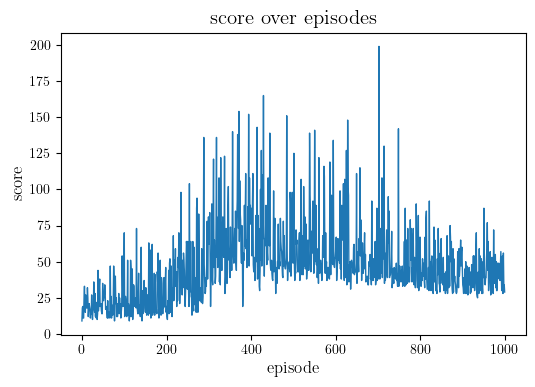

In [89]:
plt.figure(dpi=100)
plt.title('score over episodes', size=15)
plt.xlabel('episode', size=12)
plt.ylabel('score', size=12)
plt.plot(episode_scores, lw=1)

In [90]:
f = h5py.File('scores_history/' + fname_out, 'w')
f.create_dataset('gamma', data=gamma)
f.create_dataset('replay_memory_capacity', data=replay_memory_capacity)
f.create_dataset('lr', data=lr)
f.create_dataset('target_net_update_steps', data=target_net_update_steps)
f.create_dataset('batch_size', data=batch_size)
f.create_dataset('bad_state_penalty', data=bad_state_penalty)
f.create_dataset('min_samples_for_training', data=min_samples_for_training)
f.create_dataset('score_history', data=episode_scores)
f.close()

## Analizing curves

In [13]:
fname_list = os.listdir('scores_history/')
fname_list.remove('.ipynb_checkpoints')

In [14]:
fname_ref = '0.97-10000-0.01-10-128-0-1000.h5'

In [20]:
keys = ['gamma', 'replay_memory_capacity', 'lr', 'target_net_update_steps',
       'batch_size', 'bad_state_penalty', 'min_samples_for_training', 'score_history']

f = h5py.File('scores_history/' + fname_ref, 'r')
all_records = {}
for key in keys:
    all_records[key] = [f[key][()]]
f.close()

for fname in fname_list:
    if fname != fname_ref:
        f = h5py.File('scores_history/' + fname, 'r')
        for key in keys:
            all_records[key].append(f[key][()])
        f.close()

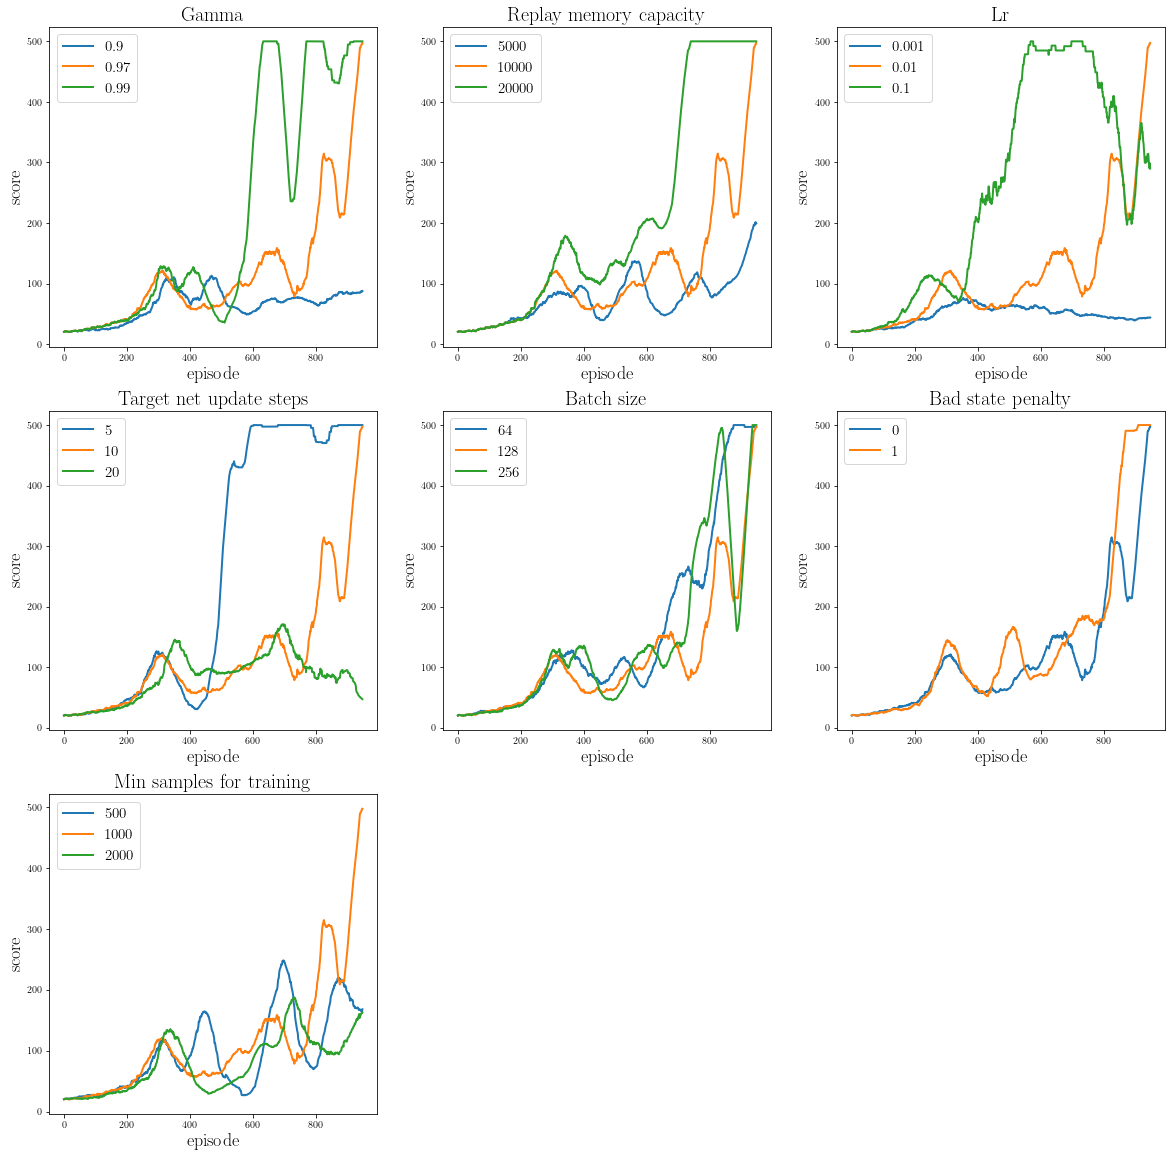

In [35]:
smoothing = 50

fig = plt.figure(figsize=(20, 20))
for i, key in enumerate(keys[:-1]):
    ax = fig.add_subplot(3, 3, i + 1)
    labels, idxs = np.unique(all_records[key], return_index=True)
    ax.set_title(key.replace('_', ' '). capitalize(), size=20)
    ax.set_xlabel('episode', size=18)
    ax.set_ylabel('score', size=18)
    for label, idx in zip(labels, idxs):
        ax.plot(np.convolve(all_records['score_history'][idx], np.ones(smoothing) / smoothing)[smoothing:-smoothing], label=label, lw=2)
    ax.legend(fontsize=15)

# Part 2: use directly the pixels as inputs

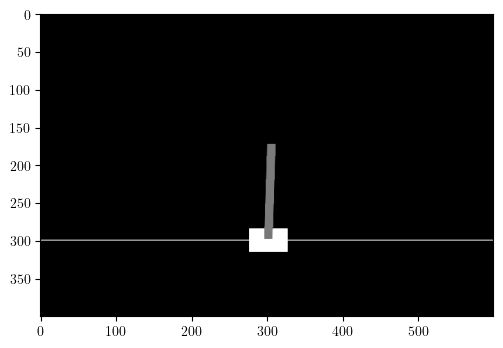

In [51]:
env = gym.make('CartPole-v1')
env.reset()

# let's take the image of the environment and turn it to greyscale
image0 = env.render(mode='rgb_array').mean(-1)

plt.figure(dpi=100)
plt.imshow(image0, cmap='Greys');

First, we want to restrict ourselves in the region around the cart. The ground line identifies the y coordinate. For the x coordinate, we can first identify the left border of the cart and then add half the width of it, which is 50.

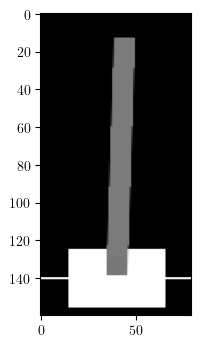

In [70]:
def get_screen(image):
    y_cart = np.where(image[:,0] == 0)[0][0]
    x_cart = np.min(np.where(image[y_cart - 10, :] == 0)[0]) + 25
    image_cropped = image[y_cart - 140 : y_cart + 20, x_cart - 40 : x_cart + 40]
    return image_cropped

plt.figure(dpi=100)
plt.imshow(get_screen(image0), cmap='Greys');

In [66]:
class DQN(nn.Module):

    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)

        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 32
        self.head = nn.Linear(linear_input_size, outputs)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))

50
